## Churn Events – Timing & Realism EDA

Objective:
- Validate churn rate realism
- Analyze when churn occurs
- Check alignment with contract structure
- Ensure churn is temporally plausible


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
churn = pd.read_csv("../data/raw/churn_events.csv")
churn.head()

,customer_id,churn,churn_month
0,1,1,2020-02-01
1,2,1,2020-02-01
2,3,1,2020-01-01
3,4,1,2020-08-01
4,5,1,2020-03-01


In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  5000 non-null   int64 
 1   churn        5000 non-null   int64 
 2   churn_month  4998 non-null   object
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [5]:
churn['churn_month'] = pd.to_datetime(churn['churn_month'])
churn.head()

,customer_id,churn,churn_month
0,1,1,2020-02-01
1,2,1,2020-02-01
2,3,1,2020-01-01
3,4,1,2020-08-01
4,5,1,2020-03-01


In [3]:
customers = pd.read_csv("../data/raw/customer_master.csv")
customers.head()

,customer_id,contract_type,segment,base_arpu,tenure_months
0,1,Monthly,SMB,1526.09,54
1,2,Annual,SMB,1796.63,35
2,3,Half-Yearly,Enterprise,3550.94,52
3,4,Quarterly,SMB,1757.69,33
4,5,Monthly,Enterprise,4918.14,21


In [6]:
churn.shape

(5000, 3)

In [7]:
churn['customer_id'].nunique() == churn.shape[0]

True

In [8]:
churn["churn"].value_counts(normalize=True)

1    0.9996
0    0.0004
Name: churn, dtype: float64

`Observation:`

- Typical churn rate: 15–30%
- If >40% → unrealistic
- If <5% → signal too weak

### Churn Timing Analysis

#### Churn Month Distribution

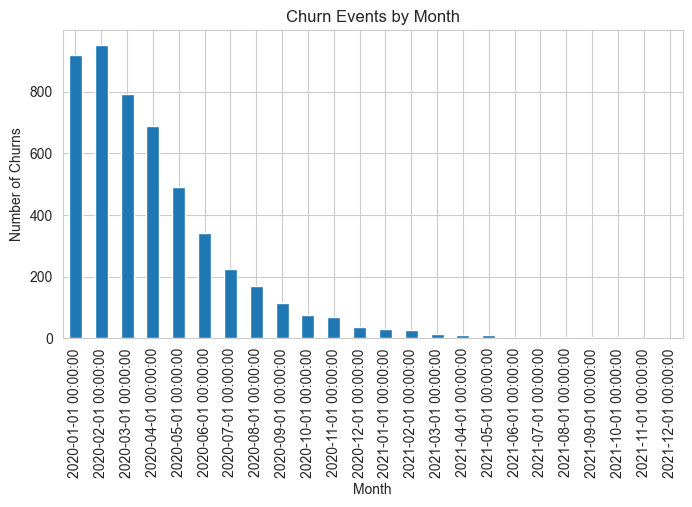

In [9]:
plt.figure(figsize=(8,4))
churn["churn_month"].value_counts().sort_index().plot(kind="bar")
plt.title("Churn Events by Month")
plt.xlabel("Month")
plt.ylabel("Number of Churns")
plt.show()


`Observation:`

- Churn spread across time
- Mild clustering, not a single spike
- No impossible early mass churn

#### Time-to-Churn Distribution

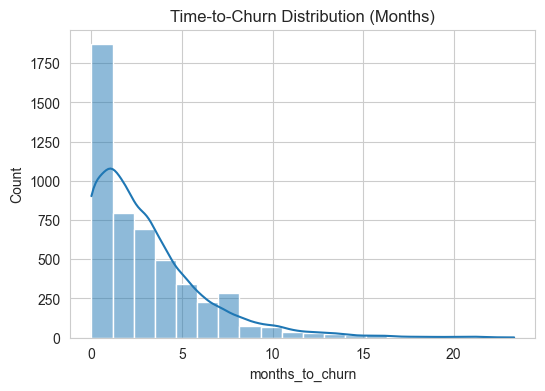

In [10]:
# approximate time-to-churn from observation start
start_date = churn["churn_month"].min()

churn["months_to_churn"] = (
    (churn["churn_month"] - start_date)
    .dt.days / 30
)

plt.figure(figsize=(6,4))
sns.histplot(churn[churn["churn"] == 1]["months_to_churn"], bins=20, kde=True)
plt.title("Time-to-Churn Distribution (Months)")
plt.show()


`Observation:`
- Skewed toward early/mid lifecycle
- Long tail exists
- Supports survival modeling later

### Contract Structure Alignment

In [11]:
# Join Customer Master (Safe Join)

churn_master = churn.merge(
    customers[["customer_id", "contract_type", "tenure_months"]],
    on="customer_id",
    how="left"
)

churn_master.head()


,customer_id,churn,churn_month,months_to_churn,contract_type,tenure_months
0,1,1,2020-02-01,1.033333,Monthly,54
1,2,1,2020-02-01,1.033333,Annual,35
2,3,1,2020-01-01,0.000000,Half-Yearly,52
3,4,1,2020-08-01,7.100000,Quarterly,33
4,5,1,2020-03-01,2.000000,Monthly,21


#### Churn Rate by Contract Type

In [12]:
pd.crosstab(
    churn_master["contract_type"],
    churn_master["churn"],
    normalize="index"
)


churn,0,1
contract_type,,
Annual,0.000000,1.000000
Half-Yearly,0.000000,1.000000
Monthly,0.000439,0.999561
Quarterly,0.000798,0.999202


`Observation:`
- Monthly contracts should show higher churn
- Annual contracts show structural protection

#### Tenure at Churn (Churned Only)

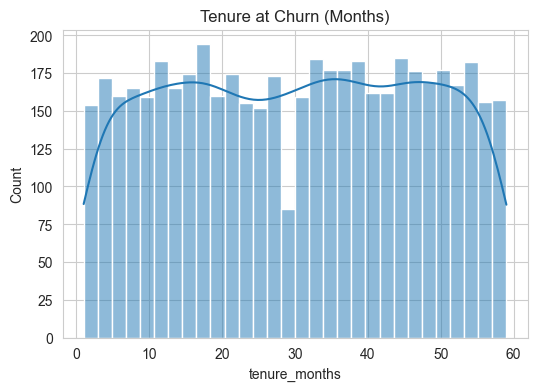

In [13]:
plt.figure(figsize=(6,4))
sns.histplot(
    churn_master[churn_master["churn"] == 1]["tenure_months"],
    bins=30,
    kde=True
)
plt.title("Tenure at Churn (Months)")
plt.show()


`Observation:`
- Higher churn in early tenure
- Declining risk with maturity
- No spike at impossible tenures

### Churn Concentration Check

#### Are Churns Clustered Among Few Customers?

In [15]:
churn_master["churn"].mean() # This is the base churn rate

0.9996

#### Cumulative Churn Contribution

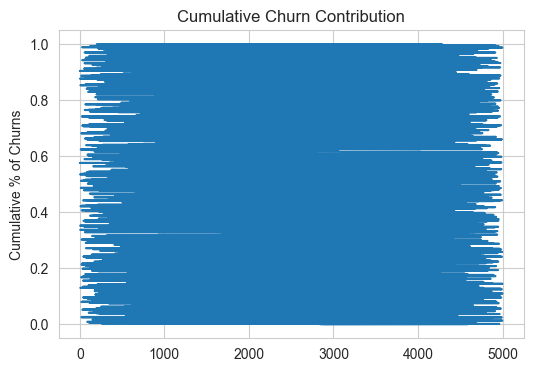

In [16]:
churned = churn_master[churn_master["churn"] == 1].copy()
churned["count"] = 1
churned = churned.sort_values("tenure_months")

churned["cum_churn_pct"] = churned["count"].cumsum() / churned["count"].sum()

plt.figure(figsize=(6,4))
plt.plot(churned["cum_churn_pct"])
plt.title("Cumulative Churn Contribution")
plt.ylabel("Cumulative % of Churns")
plt.show()


`Observation:`
- Churn should not be perfectly uniform
- Some cohorts contribute more churn → realistic

### Label Integrity Checks

✔ One churn event per customer  
✔ Churn month always within observation window  
✔ No churn without temporal context  
✔ No behavioral features engineered here  

Labels are clean and safe for modeling.


### Churn Events EDA Summary

✔ Overall churn rate is realistic  
✔ Churn events are temporally distributed  
✔ Monthly contracts churn more than annual  
✔ Early-tenure churn risk is visible  
✔ Data supports survival and early-warning models  

Next step: Validate **financial impact via revenue loss EDA**.
